In [13]:
# importing libraries
import boto3
import pandas as pd; pd.set_option('display.max_columns', 50)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report
import precision_recall_cutoff

# defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'webster-data445-bucket'
bucket = s3.Bucket(bucket_name)

# defining the csv file
file_key = 'turnover.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# reading the csv file
turnover = pd.read_csv(file_content_stream)
# dropping missing values
turnover = turnover.dropna()
turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [14]:
# changing sales to dummy variable
turnover = pd.concat([turnover.drop(columns = ['sales']), pd.get_dummies(turnover['sales'])], axis = 1)

# changing salary to dummy variable
turnover = pd.concat([turnover, pd.get_dummies(turnover['salary'])], axis = 1)
turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,high,low,medium
0,0.38,0.53,2,157,3,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,medium,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,medium,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0


In [15]:
# creating interactions from the decision tree
turnover['interaction_1'] = np.where((turnover['satisfaction_level'] <= 0.465) & (turnover['number_project'] <= 2.5) & (turnover['last_evaluation'] <= 0.575), 1, 0)
turnover['interaction_2'] = np.where((turnover['satisfaction_level'] <= 0.465) & (turnover['number_project'] >= 2.5) & (turnover['satisfaction_level'] <= 0.115), 1, 0)
turnover['interaction_3'] = np.where((turnover['satisfaction_level'] >= 0.465) & (turnover['time_spend_company'] <= 4.5) & (turnover['average_montly_hours'] <= 290.5), 1, 0)
turnover.head()


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,high,low,medium,interaction_1,interaction_2,interaction_3
0,0.38,0.53,2,157,3,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,medium,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,0.11,0.88,7,272,4,0,1,0,medium,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
3,0.72,0.87,5,223,5,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,0.37,0.52,2,159,3,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0


In [16]:
# defining input and target variables
X = turnover.drop(columns = ['left', 'salary'], axis = 1)
Y = turnover['left']

# splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

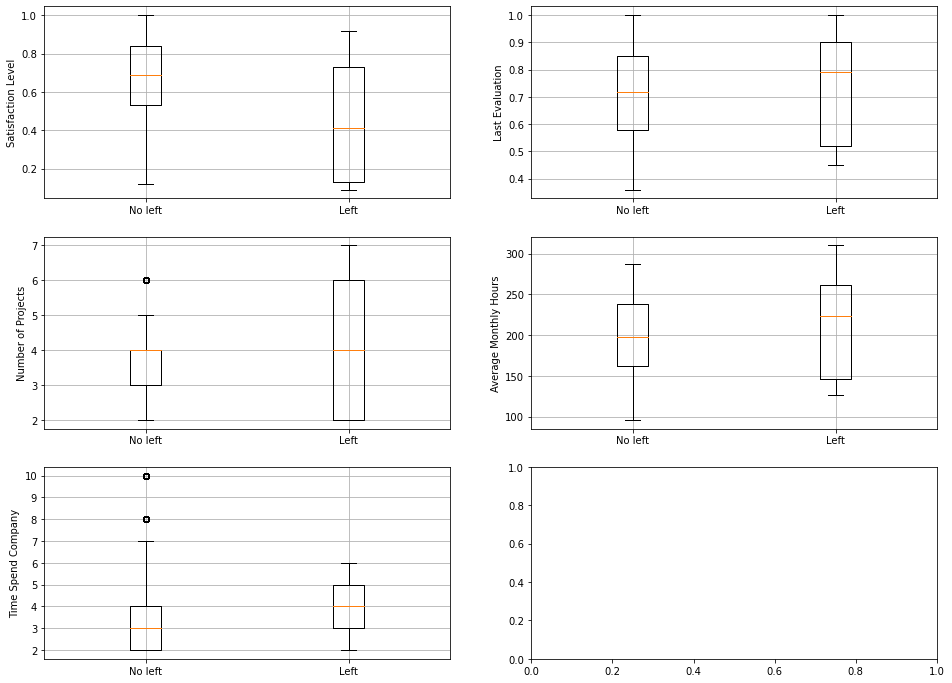

In [24]:
turnover_train = pd.concat([X_train, Y_train], axis = 1)

# creating a new figure
fig, axes = plt.subplots(3, 2, figsize = (16, 12))

# subsetting data
left = turnover_train[turnover_train['left'] == 1]
no_left = turnover_train[turnover_train['left'] == 0]

axes[0, 0].boxplot([no_left['satisfaction_level'], left['satisfaction_level']], labels = ['No left', 'Left'])
axes[0, 0].set_ylabel('Satisfaction Level')
axes[0, 0].grid()

axes[0, 1].boxplot([no_left['last_evaluation'], left['last_evaluation']], labels = ['No left', 'Left'])
axes[0, 1].set_ylabel('Last Evaluation')
axes[0, 1].grid()

axes[1, 0].boxplot([no_left['number_project'], left['number_project']], labels = ['No left', 'Left'])
axes[1, 0].set_ylabel('Number of Projects')
axes[1, 0].grid()

axes[1, 1].boxplot([no_left['average_montly_hours'], left['average_montly_hours']], labels = ['No left', 'Left'])
axes[1, 1].set_ylabel('Average Monthly Hours')
axes[1, 1].grid()

axes[2, 0].boxplot([no_left['time_spend_company'], left['time_spend_company']], labels = ['No left', 'Left'])
axes[2, 0].set_ylabel('Time Spend Company')
axes[2, 0].grid()

In [25]:
pd.crosstab(turnover_train['Work_accident'], turnover_train['left'], normalize = 'index')

left,0,1
Work_accident,,
0,0.733949,0.266051
1,0.929029,0.070971
